In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [4]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [6]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [7]:
btc_trace = go.Scatter(x=data.index, y=data['spindx'], name= 'spi')
py.iplot([btc_trace])

In [8]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [9]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [10]:
values = data['spindx'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
values

array([[ 278.21],
       [ 280.17],
       [ 282.16],
       ...,
       [2711.74],
       [2740.37],
       [2723.06]], dtype=float32)

In [12]:
scaled

array([[0.02005667],
       [0.02078077],
       [0.02151594],
       ...,
       [0.9190898 ],
       [0.92966676],
       [0.9232718 ]], dtype=float32)

In [13]:
#split dataset into train and test, 70% train 30% test

In [14]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [15]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 3 #use 3 previous days to predict the next day
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

5548
2377


In [17]:
trainX

array([[0.02005667, 0.02078077, 0.02151594],
       [0.02078077, 0.02151594, 0.02408352],
       [0.02151594, 0.02408352, 0.02394314],
       ...,
       [0.24344343, 0.2533554 , 0.25277168],
       [0.2533554 , 0.25277168, 0.2510501 ],
       [0.25277168, 0.2510501 , 0.24545687]], dtype=float32)

In [18]:
trainY

array([0.02408352, 0.02394314, 0.02469309, ..., 0.2510501 , 0.24545687,
       0.2449655 ], dtype=float32)

In [19]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
trainX

array([[[0.02005667, 0.02078077, 0.02151594]],

       [[0.02078077, 0.02151594, 0.02408352]],

       [[0.02151594, 0.02408352, 0.02394314]],

       ...,

       [[0.24344343, 0.2533554 , 0.25277168]],

       [[0.2533554 , 0.25277168, 0.2510501 ]],

       [[0.25277168, 0.2510501 , 0.24545687]]], dtype=float32)

In [21]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

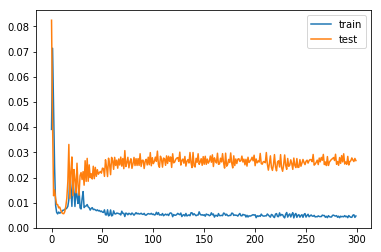

In [22]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

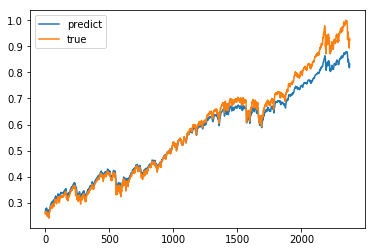

In [23]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [24]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [25]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 104.752


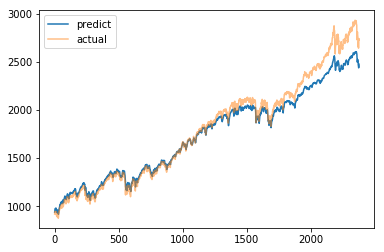

In [26]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [27]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [28]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

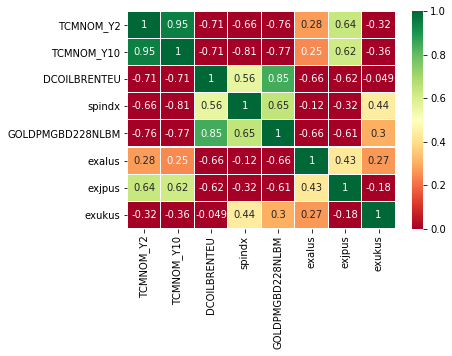

In [29]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [9]:
#data[['spindx'] + ['TCMNOM_Y2']]

In [10]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [11]:
#normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
#convert data to become supervised 
look_back = 30
time_steps = 5
reframed = series_to_supervised(scaled, look_back, time_steps)
reframed.head()

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var5(t-30),var6(t-30),var7(t-30),var8(t-30),var1(t-29),var2(t-29),...,var7(t+3),var8(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4)
48,0.029865,0.748975,0.779910,0.072673,0.121757,0.415235,0.816465,0.393284,0.029884,0.743852,...,0.888335,0.448776,0.034103,0.774590,0.839729,0.085651,0.134332,0.449931,0.907342,0.464143
49,0.029884,0.743852,0.774266,0.073637,0.120844,0.408794,0.818841,0.392999,0.030209,0.745902,...,0.907342,0.464143,0.034923,0.767418,0.828442,0.079347,0.132140,0.444864,0.891304,0.454752
50,0.030209,0.745902,0.778781,0.073786,0.121422,0.410598,0.818247,0.397837,0.030682,0.746926,...,0.891304,0.454752,0.036268,0.767418,0.830700,0.078977,0.131470,0.449244,0.899620,0.457314
51,0.030682,0.746926,0.782167,0.073786,0.119474,0.412144,0.823592,0.412635,0.031672,0.743852,...,0.899620,0.457314,0.036604,0.771516,0.827314,0.078235,0.128669,0.449072,0.901046,0.468127
52,0.031672,0.743852,0.774266,0.074156,0.112776,0.411800,0.833690,0.435970,0.031221,0.746926,...,0.901046,0.468127,0.038451,0.773566,0.831828,0.076604,0.126842,0.452422,0.895700,0.468127


In [13]:
#splitting data 
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [14]:
# split into input and outputs
#number_of_variables = 3
target = -1 * number_of_variables

train_X, train_y = train[:, :(look_back * number_of_variables)], train[:, target:]
test_X, test_y = test[:, :(look_back * number_of_variables) ], test[:, target:]


In [15]:
train_X
#test_X

array([[0.0298652 , 0.7489754 , 0.7799097 , ..., 0.44890064, 0.8869092 ,
        0.4319862 ],
       [0.02988367, 0.74385244, 0.7742663 , ..., 0.45156306, 0.89166075,
        0.43027878],
       [0.03020877, 0.74590164, 0.77878106, ..., 0.45061833, 0.87823707,
        0.43710864],
       ...,
       [0.2565547 , 0.1147541 , 0.28103834, ..., 0.25936097, 0.23699218,
        0.37820137],
       [0.25761127, 0.11168033, 0.2731377 , ..., 0.25103062, 0.22356862,
        0.35429692],
       [0.24719688, 0.1034836 , 0.26523703, ..., 0.24012357, 0.23176533,
        0.33010805]], dtype=float32)

In [16]:
train_y
#test_y

array([[0.03410263, 0.77459013, 0.8397292 , ..., 0.4499312 , 0.90734154,
        0.4641434 ],
       [0.03492278, 0.767418  , 0.82844245, ..., 0.44486433, 0.89130443,
        0.45475233],
       [0.03626752, 0.767418  , 0.83069974, ..., 0.4492442 , 0.8996199 ,
        0.45731366],
       ...,
       [0.285633  , 0.10860656, 0.2731377 , ..., 0.24390239, 0.23568541,
        0.34832084],
       [0.29058343, 0.11885247, 0.28442436, ..., 0.24708003, 0.26051325,
        0.35885024],
       [0.28933474, 0.11065574, 0.27426636, ..., 0.24630708, 0.25552398,
        0.37763238]], dtype=float32)

In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [18]:
train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2604, 1, 240) (2604, 1, 8) (1117, 1, 240) (1117, 1, 8)


In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [20]:
multi_model = Sequential()
multi_model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=train_X.shape[1]))
#model.add(Dropout(0.2))
multi_model.add(LSTM(
    100,
    return_sequences=True))
#model.add(Dropout(0.2))
multi_model.add(TimeDistributed(Dense(number_of_variables)))
#model.add(Activation("linear"))
multi_model.compile(loss="mse", optimizer="rmsprop")
multi_history = multi_model.fit(train_X, train_y, epochs=30, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Train on 2604 samples, validate on 1117 samples
Epoch 1/30


InternalError: Blas GEMV launch failed:  m=1, n=50
	 [[{{node lstm_1/while/MatMul_7}} = MatMul[T=DT_FLOAT, _class=["loc:@training/RMSprop/gradients/AddN_10"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_1/while/Switch_3:1, lstm_1/while/MatMul_7/Enter)]]
	 [[{{node loss/mul/_77}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3047_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

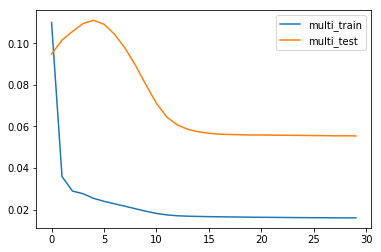

In [44]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

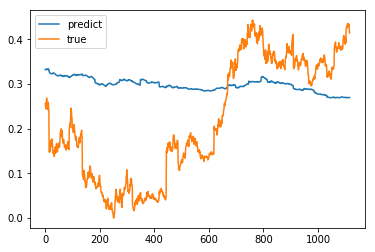

In [45]:
#plot prediction
yhat = multi_model.predict(test_X)
#yhat
pyplot.plot(yhat[:,0][:,0], label='predict')
pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.legend()
pyplot.show()

In [46]:
#yhat[:,0][:,0]

In [47]:
#DON't LOOK BELOW

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: all the input arrays must have same number of dimensions

In [138]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.007


In [139]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])